In [1]:
import os
import numpy as np

os.getcwd()


'/lustre/home/rahmanr12/github-toxic/verifier-input-feature-generator/verifier-training'

In [2]:
!ls

active-learning
analysis-flan-t5-base.ipynb
analysis-llama-3.2-3B-instruct.ipynb
analysis-text-descriptive-features.ipynb
analysis-venv
capital_letters_toxicity.png
comment_distribution.png
conversationFormatter-openai-api.ipynb
dataset
feature_importance.png
original_vs_formatted_diff_generator.ipynb
output
result_merger.ipynb
select_incorrect_data-only_incorrect-v008-model_with_qwen_added_200.ipynb
select_incorrect_data-only_incorrect-v009-model_with_qwen-final.ipynb
test.ipynb
verifier_model_selected_feature_oversampling-bert.ipynb
verifier_model_selected_feature_oversampling-best.ipynb
verifier_model_selected_feature_oversampling-experiment_with_top_features.ipynb
verifier_model_selected_feature_oversampling-LOOCV.ipynb
verifier_model_selected_feature_oversampling-v1.ipynb
verifier_model_selected_feature_oversampling-v2-miller_data.ipynb
verifier_model_selected_feature_oversampling-v3-handcrafted_features.ipynb
verifier_model_selected_feature_oversampling-v4-miller_data_handcrafted

In [3]:
!cd analysis

/bin/bash: line 1: cd: analysis: No such file or directory


In [4]:
# new_directory = '/lustre/home/rahmanr12/github-toxic/verifier-input-feature-generator/analysis'

# # Change the current working directory
# os.chdir(new_directory)

In [5]:
os.getcwd()

'/lustre/home/rahmanr12/github-toxic/verifier-input-feature-generator/verifier-training'

In [6]:
# !python3 -m venv analysis-venv
!source analysis-venv/bin/activate


In [7]:
# %pip uninstall scikit-learn imbalanced-learn
%pip install scikit-learn==1.3.0 imbalanced-learn==0.11.0
%pip install emoji


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE
from IPython.display import display
import re
import emoji
import joblib
import random

/lustre/home/rahmanr12/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [9]:
model_dir_name = 'flan-t5-base'

In [10]:
random_state = 42
np.random.seed(random_state)
random.seed(random_state)
import os
os.environ['PYTHONHASHSEED'] = str(random_state)

In [ ]:
# github-toxic/dataset/derailment-paper-data/unified_final_dataset_conversations.csv
file_path = '/path/to/input/files' % replace with real path

df_unified_conv = pd.read_csv(file_path)
df_unified_conv=df_unified_conv.rename(columns={
    "speaker_text":"conversation"
})

# df_unified_conv2 = pd.read_csv(file_path)
# df_unified_conv2['is_toxic']=1


# df_unified_conv =  pd.concat([df_unified_conv, df_unified_conv2], axis=0).reset_index(drop=True)
df_unified_conv['issue_id'] = df_unified_conv['issue_id'].astype(str)
df_unified_conv

,issue_id,conversation,is_toxic
0,12543441,jmikola: @jwage: Please take a look at the fir...,0
1,12586758,jmikola: - `closureToMongo()` is never used an...,0
2,12604115,sergponomaryov: `PersistentCollection::count()...,0
3,12662380,zxiest: bundle exec rake RAILS_ENV=production ...,0
4,12680086,"jmikola: This includes commits from #203, reba...",0
...,...,...,...
893,2044991681,Shane9248: ### Application\nYouTube ReVanced\n...,0
894,2044991682,muchisx: ### Type\nError at runtime\n### Bug d...,0
895,2044991685,Qaz-7: ### Application\nTelegram\n### Issue\nU...,0
896,2044991686,theofficialgman: ### Type\nError at runtime\n#...,1


In [12]:
second_person_pronouns = ['you', 'your', 'yours', 'yourself', 'yourselves']
def count_second_person_pronouns(text):
    count = 0
    words = text.lower().split()
    for pronoun in second_person_pronouns:
        count += words.count(pronoun)
    return count

In [ ]:
file_path = '/path/to/input/files' % replace with real path
df_unified_comment_data = pd.read_csv(file_path)
# df_unified_comment_data = pd.read_csv(file_path)

df_unified_comment_data

,issue_id,speaker,comment_sequence,comment_unique_id,text,toxic,timestamp
0,12543441,jmikola,1,12543441,@jwage: Please take a look at the first commit...,0,2013-03-28T00:23:29Z
1,12543441,tystr,2,15655171,:thumbsup: Seems correct to throw an exception...,0,2013-03-29T18:53:51Z
2,12543441,jmikola,3,15741721,Note: this will need rebasing if #546 is merge...,0,2013-04-01T22:38:19Z
3,12543441,jwage,4,17141038,:+1:,0,2013-04-28T19:38:17Z
4,12586758,jmikola,1,12586758,- `closureToMongo()` is never used and should ...,0,2013-03-28T21:57:18Z
...,...,...,...,...,...,...,...
8868,2044991706,Al-1A,11,1858985684,I'm affected too... It (the video ) stops & st...,0,2022-10-25T06:01:28Z
8869,2044991706,TheMaskedAvengers,12,1858985693,Same symptoms here. Also in UK. Solved by VPN....,0,2022-10-25T07:42:47Z
8870,2044991706,TheMaskedAvengers,13,1858985700,I'm posting with data sincerely trying to help...,0,2022-10-25T12:50:35Z
8871,2044991706,oSumAtrIX,14,1858985707,Your information is already posted on this iss...,0,2022-10-25T13:59:14Z


In [ ]:
# df_miller_comment_data = pd.read_csv(file_path)
# df_miller_comment_data=df_miller_comment_data.rename(columns={
#     "comment_id":"comment_unique_id"
# })
# df_miller_comment_data

In [15]:
# miller_issue_ids = df_miller_comment_data['issue_id'].unique()

In [16]:
# df_unified_comment_data=df_unified_comment_data[df_miller_comment_data.columns]

# df_unified_comment_data = pd.concat([df_unified_comment_data, df_miller_comment_data], axis=0).reset_index(drop=True)
# df_unified_comment_data

In [17]:
df_unified_comment_data['text'] = df_unified_comment_data['text'].astype(str).replace({'nan': '', '': ''})
df_unified_comment_data['text'] = df_unified_comment_data['text'].astype(str).fillna('')
df_unified_comment_data['pronoun_count'] = df_unified_comment_data['text'].apply(count_second_person_pronouns)
df_unified_comment_data['comment_length'] = df_unified_comment_data['text'].apply(len)


In [18]:

# First, group by 'issue_id' and 'speaker_name' and count the comments per speaker
speaker_comment_counts = df_unified_comment_data.groupby(['issue_id', 'speaker']).size()
speaker_comment_counts

issue_id    speaker          
12543441    jmikola              2
            jwage                1
            tystr                1
12586758    jmikola              2
            malarzm              2
                                ..
2044991706  TheMaskedAvengers    3
            amazingakita         1
            oSumAtrIX            3
            plexay               1
            scottyell            1
Length: 3690, dtype: int64

In [19]:
max_comments_per_issue_by_speakers = speaker_comment_counts.groupby(level=0).max()
max_comments_per_issue_by_speakers

issue_id
12543441      2
12586758      2
12604115      2
12662380      4
12680086      2
             ..
2044991681    4
2044991682    4
2044991685    5
2044991686    3
2044991706    3
Length: 898, dtype: int64

In [20]:
# Define a function to count '@' in each comment
def count_at_signs(text):
    text = text or ''
    
    try:
        return text.count('@')
    except Exception as e:
        # Catch all other exceptions
        # print("An error occurred:", e)
        return 0
    
def count_quotes(text):
    try:
        return text.count("'") + text.count('"') + text.count('`')
    except Exception as e:
        # print("An error occurred:", e)
        return 0
    
def count_hashes(text):
    try:
        return text.count("#")
    except Exception as e:
        # print("An error occurred:", e)
        return 0

In [21]:
def count_words(text):
    return len(str(text).split())

def count_quote_markers(text):
    # Check if the text contains "> " and return 1 if true, 0 if false
    return 1 if "> " in str(text) else 0


# Get max number of comments per speaker per issue
median_comments_per_issue_by_speakers = speaker_comment_counts.groupby(level=0).median()

# Group by 'issue_id' and aggregate
aggregated_data = df_unified_comment_data.groupby('issue_id').agg(
    comment_counts=('comment_unique_id', 'count'),  # Count of comments
    unique_speakers=('speaker', 'nunique'),  # Count of unique speaker names
    total_second_person_pronouns=('pronoun_count', 'sum'),
    max_comment_length=('comment_length', 'max'),  # Maximum length of comments,
    total_ats=('text', lambda x: x.apply(count_at_signs).sum()),  # Sum of '@' in all comments
    total_quotes=('text', lambda x: x.apply(count_quotes).sum()),  # Sum of quote characters in all comments
    median_words_in_comment=('text', lambda x: x.apply(count_words).median()),
    std_dev_words_in_comment=('text', lambda x: x.apply(count_words).std()),
    max_words_in_comment=('text', lambda x: x.apply(count_words).max()),
    total_previous_comment_mentions=('text', lambda x: x.apply(count_quote_markers).sum()),  # Count of comments with "> "

)

aggregated_data['max_comments_by_one_speaker'] = aggregated_data.index.map(max_comments_per_issue_by_speakers)
aggregated_data['median_comments_by_one_speaker'] = aggregated_data.index.map(median_comments_per_issue_by_speakers)


# Reset index to make 'issue_id' a column again
aggregated_data.reset_index(inplace=True)

aggregated_data

,issue_id,comment_counts,unique_speakers,total_second_person_pronouns,max_comment_length,total_ats,total_quotes,median_words_in_comment,std_dev_words_in_comment,max_words_in_comment,total_previous_comment_mentions,max_comments_by_one_speaker,median_comments_by_one_speaker
0,12543441,4,3,2,286,1,3,17.5,23.216374,54,0,2,1.0
1,12586758,4,2,0,406,3,14,41.0,24.984995,72,1,2,2.0
2,12604115,4,3,0,517,0,16,34.5,34.451657,66,0,2,1.0
3,12662380,8,3,2,361,1,37,27.0,20.406144,55,0,4,2.0
4,12680086,5,3,2,393,2,9,36.0,22.154006,49,0,2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,2044991681,9,4,2,742,0,23,26.0,41.985447,114,4,4,2.0
894,2044991682,11,6,3,878,2,25,33.0,44.764028,151,3,4,1.5
895,2044991685,9,4,3,657,0,1,8.0,26.117257,86,0,5,1.5
896,2044991686,13,6,5,960,5,16,30.0,45.576225,162,4,3,2.0


In [ ]:
def check_is_closed(group):
    last_two_comments = group.tail(2)  # Get the last 2 comments for the issue_id
    return int(last_two_comments['text'].str.contains(r'\bclose\b', case=False).any())

# Group by issue_id and apply the function
aggregated_data2 = df_unified_comment_data.groupby('issue_id').apply(
    lambda group: pd.Series({'is_issue_closed': check_is_closed(group)})
).reset_index()


def count_emojis(text):
    """
    Count the total number of emojis in a text string.
    
    Args:
        text (str): The text string to analyze (e.g., GitHub issue comment)
    
    Returns:
        int: Total number of emojis found
    """
    # Get all emojis present in the text
    emoji_list = [c for c in text if c in emoji.EMOJI_DATA]
    
    # Return the count
    return len(emoji_list)

def calculate_emoji_metrics(group):
    # Calculate total emojis across all comments for an issue_id
    total_emojis = group['text'].apply(count_emojis).sum()
    
    # Count the number of comments containing at least one emoji
    total_comments_with_emoji = group['text'].apply(lambda x: count_emojis(x) > 0).sum()
    total_comments = len(group)

    return pd.Series({
        'emoji_count': total_emojis,
        'total_comment_with_emoji': total_comments_with_emoji,
        'total_comment_with_emoji_ratio': total_comments_with_emoji/total_comments
    })

# Group by issue_id and apply the function
emoji_metrics = df_unified_comment_data.groupby('issue_id').apply(calculate_emoji_metrics).reset_index()

# Merge with the aggregated_data2
aggregated_data2 = pd.merge(aggregated_data2, emoji_metrics, on='issue_id')

# aggregated_data2['code_of_conduct_mentioned'] = df_unified_comment_data.groupby('issue_id')['text'].apply(
#     lambda comments: int(comments.str.contains("code of conduct", case=False).any())
# ).reset_index(drop=True)

def get_first_coc_mention_idx(comments):
    # Find the first occurrence of "code of conduct" in comments
    mask = comments.str.contains("code of conduct", case=False)
    # If found, return the index (starting from 1), else return 0
    if mask.any():
        return mask.idxmax() + 1  # Adding 1 to convert from 0-based to 1-based indexing
    return 0

# Apply the function to get the index of first code of conduct mention
aggregated_data2['code_of_conduct_mentioned_comment_idx'] = df_unified_comment_data.groupby('issue_id')['text'].apply(
    get_first_coc_mention_idx
).reset_index(drop=True)

aggregated_data2

/tmp/ipykernel_344373/3538772850.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aggregated_data2 = df_unified_comment_data.groupby('issue_id').apply(
/tmp/ipykernel_344373/3538772850.py:126: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  emoji_metrics = df_unified_comment_data.groupby('issue_id').apply(calculate_emoji_metrics).reset_index()


,issue_id,is_issue_closed,emoji_count,total_comment_with_emoji,total_comment_with_emoji_ratio,code_of_conduct_mentioned_comment_idx
0,12543441,0,0.0,0.0,0.000000,0
1,12586758,0,0.0,0.0,0.000000,0
2,12604115,0,0.0,0.0,0.000000,0
3,12662380,0,0.0,0.0,0.000000,0
4,12680086,0,0.0,0.0,0.000000,0
...,...,...,...,...,...,...
893,2044991681,0,3.0,1.0,0.111111,0
894,2044991682,0,0.0,0.0,0.000000,0
895,2044991685,0,1.0,1.0,0.111111,0
896,2044991686,0,0.0,0.0,0.000000,0


In [23]:
# Technical features
def has_stack_trace(text):
    st_regex = re.compile(r'at [a-zA-Z0-9\.<>$]+\(.+\)')
    return bool(st_regex.search(text))

def check_template(first_comment):
    template_indicators = ['### Description', '## Description', '### Steps to reproduce', '## Steps to reproduce']
    return int(any(indicator in first_comment for indicator in template_indicators))

# Update aggregation
def calculate_technical_features(group):
    texts = group['text'].astype(str)
    first_comment = texts.iloc[0] if not texts.empty else ""
    
    return pd.Series({
        'has_stack_trace': int(texts.apply(has_stack_trace).any()),
        'has_code': int(texts.str.contains(r'```\w*\n.*?\n```', flags=re.DOTALL).any()),
        # 'has_markdown': int(texts.str.contains(r'```').any()),
        'has_template': check_template(first_comment)
    })

technical_feature_metrics = df_unified_comment_data.groupby('issue_id').apply(calculate_technical_features).reset_index()
aggregated_data2 = pd.merge(aggregated_data2, technical_feature_metrics, on='issue_id')

/tmp/ipykernel_344373/3671448660.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  technical_feature_metrics = df_unified_comment_data.groupby('issue_id').apply(calculate_technical_features).reset_index()


In [24]:
print(aggregated_data2['code_of_conduct_mentioned_comment_idx'].isnull().sum())  # Check for NaN/None


0


In [ ]:
file_path = '/path/to/input/files' % replace with real path
df_prediction_explanation_llama = pd.read_csv(file_path)

df_prediction_explanation_llama = df_prediction_explanation_llama.rename(columns={
    'toxicity_score': 'toxicity_score_llama',
    'toxicity_explanation':'toxicity_explanation_llama'
})

file_path = '/path/to/input/files' % replace with real path

df_prediction_explanation_qwen = pd.read_csv(file_path)
df_prediction_explanation_qwen = df_prediction_explanation_qwen.rename(columns={
    'toxicity_score': 'toxicity_score_qwen',
    'toxicity_explanation':'toxicity_explanation_qwen'
})

df_prediction_explanation = pd.merge(
    df_prediction_explanation_llama[['issue_id', 'toxicity_score_llama', 'toxicity_explanation_llama']],
    df_prediction_explanation_qwen[['issue_id', 'toxicity_score_qwen', 'toxicity_explanation_qwen']],
    on='issue_id')

df_prediction_explanation['is_toxic_llm_pred_llama']= df_prediction_explanation['toxicity_score_llama']>=0.3
df_prediction_explanation['is_toxic_llm_pred_qwen']= df_prediction_explanation['toxicity_score_qwen']>=0.3

df_prediction_explanation['avg_toxicity_score'] = (df_prediction_explanation['toxicity_score_llama']+df_prediction_explanation['toxicity_score_qwen'])/2

df_prediction_explanation['toxicity_score_diff'] = abs(df_prediction_explanation['toxicity_score_llama']-df_prediction_explanation['toxicity_score_qwen'])

df_prediction_explanation



,issue_id,toxicity_score_llama,toxicity_explanation_llama,toxicity_score_qwen,toxicity_explanation_qwen,is_toxic_llm_pred_llama,is_toxic_llm_pred_qwen,avg_toxicity_score,toxicity_score_diff
0,12543441,0.05,The conversation is generally polite and const...,0.0,The conversation is professional and construct...,False,False,0.025,0.05
1,12586758,0.05,The conversation is generally constructive and...,0.0,The conversation is a technical discussion abo...,False,False,0.025,0.05
2,12604115,0.05,The conversation is generally polite and const...,0.0,The conversation is professional and construct...,False,False,0.025,0.05
3,12662380,0.20,The conversation contains some uncivil tone-be...,0.3,The conversation contains some elements of fru...,False,True,0.250,0.10
4,12680086,0.05,The conversation contains some minor instances...,0.0,The conversation is professional and focused o...,False,False,0.025,0.05
...,...,...,...,...,...,...,...,...,...
893,2044991681,0.40,The conversation contains several instances of...,0.2,The conversation is generally respectful and f...,True,False,0.300,0.20
894,2044991682,0.20,"The conversation contains some toxic elements,...",0.1,The conversation is primarily focused on troub...,False,False,0.150,0.10
895,2044991685,0.80,The conversation contains several toxic elemen...,0.2,The conversation shows some frustration and di...,True,False,0.500,0.60
896,2044991686,0.20,"The conversation contains some toxic elements,...",0.2,The conversation shows some frustration and im...,False,False,0.200,0.00


In [ ]:
file_path = '/path/to/input/files' % replace with real path

df_time_features = pd.read_csv(file_path)

df_time_features

,Unnamed: 0,issue_id,avg_comment_time,max_comment_time,std_comment_time
0,0,12543441,190.811667,644.999444,304.374441
1,1,12586758,4841.060278,19363.445000,9681.589817
2,2,12604115,751.683750,1345.782778,563.277662
3,3,12662380,5.263889,26.531944,9.409804
4,4,12680086,128.997222,617.040833,272.868424
...,...,...,...,...,...
893,893,2044991681,34.700586,177.277500,66.368915
894,894,2044991682,0.652601,5.234167,1.569317
895,895,2044991685,0.551481,2.999167,0.981052
896,896,2044991686,74.803141,861.431944,237.304904


In [ ]:
file_path = '/path/to/input/files' % replace with real path

df_tone_features = pd.read_csv(file_path)
df_tone_features['tone_score_diff']= df_tone_features['first_half_tone'].astype(float) - df_tone_features['second_half_tone'].astype(float)
df_tone_features

,first_half_tone,second_half_tone,tone_score_diff,issue_id
0,4.0,10.0,-6.0,12543441
1,6.0,10.0,-4.0,12586758
2,10.0,5.0,5.0,12604115
3,9.0,10.0,-1.0,12662380
4,8.0,9.0,-1.0,12680086
...,...,...,...,...
893,3.0,4.0,-1.0,2044991681
894,2.0,5.0,-3.0,2044991682
895,10.0,4.0,6.0,2044991685
896,4.0,7.0,-3.0,2044991686


In [ ]:
file_path = '/path/to/input/files' % replace with real path
df_text_descriptive = pd.read_csv(file_path)
# df_text_descriptive2 = pd.read_csv(file_path)
# df_text_descriptive =  pd.concat([df_text_descriptive, df_text_descriptive2], axis=0).reset_index(drop=True)


df_text_descriptive = df_text_descriptive.drop(columns=['is_toxic','text'])
df_text_descriptive = df_text_descriptive.rename(columns={col:  col+'_TD' if col != 'issue_id' else col for col in df_text_descriptive.columns})

df_text_descriptive

,issue_id,first_order_coherence_TD,second_order_coherence_TD,entropy_TD,perplexity_TD,per_word_perplexity_TD,dependency_distance_mean_TD,dependency_distance_std_TD,prop_adjacent_dependency_relation_mean_TD,prop_adjacent_dependency_relation_std_TD,...,pos_prop_NOUN_TD,pos_prop_NUM_TD,pos_prop_PART_TD,pos_prop_PRON_TD,pos_prop_PROPN_TD,pos_prop_PUNCT_TD,pos_prop_SCONJ_TD,pos_prop_SYM_TD,pos_prop_VERB_TD,pos_prop_X_TD
0,12543441,0.508928,0.512692,3.346241,2.839579e+01,2.346760e-01,3.199560,0.369128,0.447736,0.066421,...,0.157025,0.016529,0.041322,0.074380,0.024793,0.165289,0.024793,0.016529,0.148760,0.000000
1,12586758,0.384163,0.287027,5.380115,2.170472e+02,9.646543e-01,2.670102,0.795936,0.427436,0.105385,...,0.137778,0.017778,0.026667,0.084444,0.053333,0.182222,0.026667,0.004444,0.128889,0.013333
2,12604115,0.373930,0.360872,4.331333,7.604556e+01,3.691532e-01,2.466824,0.890210,0.420554,0.058558,...,0.199029,0.004854,0.024272,0.053398,0.053398,0.228155,0.019417,0.024272,0.121359,0.004854
3,12662380,0.290564,0.325161,7.649927,2.100493e+03,6.668230e+00,2.405535,1.433957,0.418711,0.069556,...,0.133333,0.003175,0.038095,0.092063,0.038095,0.234921,0.022222,0.000000,0.111111,0.009524
4,12680086,0.357455,0.274836,4.941469,1.399757e+02,6.059555e-01,2.731145,1.676319,0.378487,0.136378,...,0.129870,0.017316,0.021645,0.056277,0.121212,0.186147,0.021645,0.073593,0.090909,0.017316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,2044991681,0.361696,0.369314,11.678909,1.180554e+05,2.166155e+02,2.304192,0.987748,0.412690,0.069259,...,0.133945,0.001835,0.023853,0.104587,0.031193,0.110092,0.014679,0.018349,0.091743,0.047706
894,2044991682,0.367625,0.287388,19.037100,1.852283e+08,2.329916e+05,2.553656,1.663956,0.410853,0.097301,...,0.173585,0.022642,0.007547,0.069182,0.032704,0.183648,0.010063,0.027673,0.115723,0.026415
895,2044991685,0.407466,0.393931,5.959822,3.875411e+02,1.556390e+00,2.240237,1.124115,0.453424,0.103688,...,0.160643,0.012048,0.012048,0.044177,0.092369,0.164659,0.008032,0.040161,0.096386,0.040161
896,2044991686,0.334522,0.243177,18.971547,1.734755e+08,2.209879e+05,2.345632,1.187042,0.394308,0.148308,...,0.163057,0.008917,0.033121,0.076433,0.034395,0.138854,0.014013,0.024204,0.133758,0.024204


In [29]:
len(df_text_descriptive.columns)

70

In [ ]:
file_path = '/path/to/input/files' % replace with real path
df_text_content_features= pd.read_csv(file_path)
# df_text_content_features2 = pd.read_csv(file_path)
# df_text_content_features =  pd.concat([df_text_content_features, df_text_content_features2], axis=0).reset_index(drop=True)

df_text_content_features=df_text_content_features.drop(columns=['is_toxic', 'speaker_text'])
df_text_content_features

,issue_id,question_mark_count,negative_word_count
0,12543441,0,0
1,12586758,1,1
2,12604115,0,1
3,12662380,1,3
4,12680086,2,2
...,...,...,...
893,2044991681,6,8
894,2044991682,1,2
895,2044991685,0,3
896,2044991686,4,25


In [ ]:
emotions= [
            # 'admiration', 'amusement',
    'anger', 'annoyance', 'approval',
    # 'caring',
            'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
            'disgust', 'embarrassment', 
    # 'excitement', 'fear', 'gratitude', 'grief',
            # 'joy', 'love', 'nervousness', 'neutral', 'optimism', 
    'pride',
    # 'realization', 'relief', 'remorse', 
    'sadness', 'surprise'
        ]

file_path = '/path/to/input/files' % replace with real path

df_emotion_scores = pd.read_csv(file_path)
# df_emotion_scores2 = pd.read_csv(file_path)
# df_emotion_scores =  pd.concat([df_emotion_scores, df_emotion_scores2], axis=0).reset_index(drop=True)

df_emotion_scores= df_emotion_scores[emotions+['issue_id']]
df_emotion_scores

,anger,annoyance,approval,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,pride,sadness,surprise,issue_id
0,0.000182,0.000726,0.002426,0.000719,0.000463,0.000356,0.000319,0.001289,0.000185,0.000101,0.001236,0.000115,0.998979,12543441
1,0.000624,0.002690,0.003760,0.201649,0.028806,0.002813,0.002943,0.000795,0.000517,0.000647,0.014778,0.000720,0.972754,12586758
2,0.000182,0.001157,0.000590,0.000778,0.000268,0.000194,0.000335,0.000381,0.000115,0.000236,0.004517,0.000373,0.208938,12604115
3,0.002917,0.013412,0.000486,0.980276,0.020246,0.000056,0.006273,0.015282,0.002277,0.002492,0.007884,0.001476,0.119652,12662380
4,0.000250,0.000579,0.000690,0.005122,0.002076,0.000199,0.000275,0.000562,0.000221,0.000144,0.000606,0.000254,0.998832,12680086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,0.031608,0.190782,0.001963,0.445085,0.245069,0.002155,0.051667,0.008633,0.003485,0.043622,0.097284,0.007332,0.880478,2044991681
894,0.000403,0.072299,0.004177,0.001526,0.001409,0.000368,0.014131,0.012712,0.000429,0.000750,0.013100,0.000340,0.998928,2044991682
895,0.000337,0.001700,0.000566,0.005799,0.001836,0.000253,0.001013,0.016703,0.000730,0.000232,0.000664,0.000149,0.998395,2044991685
896,0.004316,0.963681,0.005587,0.018232,0.023974,0.000477,0.289459,0.020178,0.002508,0.005537,0.075651,0.002206,0.988794,2044991686


In [ ]:
file_path = '/path/to/input/files' % replace with real path
df_sentiment_polarity_senticr = pd.read_csv(file_path)
# df_sentiment_polarity_senticr2 = pd.read_csv(file_path)
# df_sentiment_polarity_senticr =  pd.concat([df_sentiment_polarity_senticr, df_sentiment_polarity_senticr2], axis=0).reset_index(drop=True)

df_sentiment_polarity_senticr

,issue_id,has_neg_comment_sentcr,non_neg_comment_ratio_sentcr,neg_comment_ratio_sentcr,sentiment_transition_ratio_sentcr,total_non_neg_comment,total_neg_comment,total_transitions
0,12543441,0.0,1.000000,0.000000,0.000000,4.0,0.0,0.0
1,12586758,1.0,0.750000,0.250000,0.500000,3.0,1.0,2.0
2,12604115,0.0,1.000000,0.000000,0.000000,4.0,0.0,0.0
3,12662380,1.0,0.875000,0.125000,0.250000,7.0,1.0,2.0
4,12680086,0.0,1.000000,0.000000,0.000000,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...
893,2044991681,1.0,0.444444,0.555556,0.555556,4.0,5.0,5.0
894,2044991682,1.0,0.454545,0.545455,0.545455,5.0,6.0,6.0
895,2044991685,1.0,0.777778,0.222222,0.444444,7.0,2.0,4.0
896,2044991686,1.0,0.615385,0.384615,0.384615,8.0,5.0,5.0


In [33]:
df_sentiment_polarity_senticr.columns

Index(['issue_id', 'has_neg_comment_sentcr', 'non_neg_comment_ratio_sentcr',
       'neg_comment_ratio_sentcr', 'sentiment_transition_ratio_sentcr',
       'total_non_neg_comment', 'total_neg_comment', 'total_transitions'],
      dtype='object')

In [34]:
df_sentiment_polarity_senticr=df_sentiment_polarity_senticr[['issue_id', 'has_neg_comment_sentcr', 'non_neg_comment_ratio_sentcr',
       'neg_comment_ratio_sentcr', 'sentiment_transition_ratio_sentcr']]


In [ ]:
file_path = '/path/to/input/files' % replace with real path
df_sentiment_polarity_textblob = pd.read_csv(file_path)
# df_sentiment_polarity_textblob2 = pd.read_csv(file_path)
# df_sentiment_polarity_textblob =  pd.concat([df_sentiment_polarity_textblob, df_sentiment_polarity_textblob2], axis=0).reset_index(drop=True)

df_sentiment_polarity_textblob

,issue_id,has_neg_comment_textblob,non_neg_comment_ratio_textblob,neg_comment_ratio_textblob,sentiment_transition_ratio_textblob,total_non_neg_comment_textblob,total_neg_comment_textblob,total_transitions_textblob,max_consecutive_negatives_textblob
0,12543441,0.0,1.000000,0.000000,0.000000,4.0,0.0,0.0,0.0
1,12586758,1.0,0.500000,0.500000,0.750000,2.0,2.0,3.0,0.0
2,12604115,1.0,0.750000,0.250000,0.500000,3.0,1.0,2.0,0.0
3,12662380,1.0,0.750000,0.250000,0.500000,6.0,2.0,4.0,0.0
4,12680086,1.0,0.800000,0.200000,0.400000,4.0,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...
893,2044991681,1.0,0.444444,0.555556,0.333333,4.0,5.0,3.0,3.0
894,2044991682,1.0,0.636364,0.363636,0.454545,7.0,4.0,5.0,2.0
895,2044991685,1.0,0.888889,0.111111,0.222222,8.0,1.0,2.0,0.0
896,2044991686,1.0,0.769231,0.230769,0.461538,10.0,3.0,6.0,0.0


In [ ]:
file_path = '/path/to/input/files' % replace with real path
df_sentiment_polarity_vader = pd.read_csv(file_path)
# df_sentiment_polarity_vader2 = pd.read_csv(file_path)
# df_sentiment_polarity_vader =  pd.concat([df_sentiment_polarity_vader, df_sentiment_polarity_vader2], axis=0).reset_index(drop=True)

df_sentiment_polarity_vader['has_neg_comment_vader'] = df_sentiment_polarity_vader['has_neg_comment_vader'].astype(int)
df_sentiment_polarity_vader

,issue_id,has_neg_comment_vader,non_neg_comment_ratio_vader,neg_comment_ratio_vader,sentiment_transition_ratio_vader,total_non_neg_comment_vader,total_neg_comment_vader,total_transitions_vader,max_consecutive_negatives_vader
0,12543441,0,1.000000,0.000000,0.000000,4,0,0,0
1,12586758,0,1.000000,0.000000,0.000000,4,0,0,0
2,12604115,0,1.000000,0.000000,0.000000,4,0,0,0
3,12662380,1,0.625000,0.375000,0.750000,5,3,6,0
4,12680086,1,0.800000,0.200000,0.200000,4,1,1,0
...,...,...,...,...,...,...,...,...,...
893,2044991681,1,0.666667,0.333333,0.444444,6,3,4,2
894,2044991682,1,0.545455,0.454545,0.545455,6,5,6,2
895,2044991685,1,0.888889,0.111111,0.111111,8,1,1,0
896,2044991686,1,0.692308,0.307692,0.538462,9,4,7,0


In [ ]:
file_path = '/path/to/input/files' % replace with real path
df_perplexity = pd.read_csv(file_path)
# df_perplexity2 = pd.read_csv(file_path)
# df_perplexity =  pd.concat([df_perplexity, df_perplexity2], axis=0).reset_index(drop=True)

df_perplexity = df_perplexity.rename(columns={
    'perplexity': 'conversastion_perplexity'
})
df_perplexity

,issue_id,conversastion_perplexity
0,12543441,1.098666
1,12586758,1.266443
2,12604115,1.503707
3,12662380,1.251652
4,12680086,1.077684
...,...,...
893,2044991681,2.164901
894,2044991682,2.429629
895,2044991685,2.209112
896,2044991686,1.454556


In [ ]:
file_path = '/path/to/input/files' % replace with real path
df_explanation_features_given_conv = pd.read_csv(file_path)

df_explanation_features_given_conv

,issue_id,toxic_label_probability,non_toxic_label_probability
0,12543441,0.661885,0.325565
1,12586758,0.638042,0.352137
2,12604115,0.686447,0.301591
3,12662380,0.748426,0.241925
4,12680086,0.760646,0.226477
...,...,...,...
893,2044991681,0.651493,0.337699
894,2044991682,0.741328,0.247585
895,2044991685,0.758675,0.227562
896,2044991686,0.665519,0.323769


In [ ]:
file_path = '/path/to/input/files' % replace with real path
df_explanation_features_given_conv_exp = pd.read_csv(file_path)
# df_explanation_features_given_conv_exp2 = pd.read_csv(file_path)
# df_explanation_features_given_conv_exp =  pd.concat([df_explanation_features_given_conv_exp, df_explanation_features_given_conv_exp2], axis=0).reset_index(drop=True)

df_explanation_features_given_conv_exp

,issue_id,toxic_label_probability,non_toxic_label_probability
0,12543441,0.762530,0.229312
1,12586758,0.681740,0.309388
2,12604115,0.674442,0.315259
3,12662380,0.644743,0.347010
4,12680086,0.772821,0.217879
...,...,...,...
893,2044991681,0.759413,0.233437
894,2044991682,0.797978,0.193816
895,2044991685,0.728783,0.264647
896,2044991686,0.753317,0.239787


In [ ]:
file_path = '/path/to/input/files' % replace with real path
df_explanation_features_given_exp = pd.read_csv(file_path)
# df_explanation_features_given_exp2 = pd.read_csv(file_path)
# df_explanation_features_given_exp =  pd.concat([df_explanation_features_given_exp, df_explanation_features_given_exp2], axis=0).reset_index(drop=True)

df_explanation_features_given_exp

,issue_id,toxic_label_probability,non_toxic_label_probability
0,12543441,0.808291,0.182722
1,12586758,0.837311,0.154087
2,12604115,0.830042,0.160924
3,12662380,0.647381,0.344834
4,12680086,0.806047,0.185590
...,...,...,...
893,2044991681,0.833261,0.158641
894,2044991682,0.853928,0.139264
895,2044991685,0.794658,0.198138
896,2044991686,0.824360,0.169077


In [43]:

df_explanation_features_given_conv = df_explanation_features_given_conv.rename(columns=
                                     {
                                         'toxic_label_probability': 'toxic_prob_conv',
                                         'non_toxic_label_probability': 'non_toxic_prob_conv',
                                     })
df_explanation_features_given_conv

,issue_id,toxic_prob_conv,non_toxic_prob_conv
0,12543441,0.661885,0.325565
1,12586758,0.638042,0.352137
2,12604115,0.686447,0.301591
3,12662380,0.748426,0.241925
4,12680086,0.760646,0.226477
...,...,...,...
893,2044991681,0.651493,0.337699
894,2044991682,0.741328,0.247585
895,2044991685,0.758675,0.227562
896,2044991686,0.665519,0.323769


In [44]:

df_explanation_features_given_conv_exp = df_explanation_features_given_conv_exp.rename(columns=
                                                 {
                                                     'toxic_label_probability': 'toxic_prob_conv_exp',
                                                     'non_toxic_label_probability': 'non_toxic_prob_conv_exp',
                                                 })
df_explanation_features_given_conv_exp

,issue_id,toxic_prob_conv_exp,non_toxic_prob_conv_exp
0,12543441,0.762530,0.229312
1,12586758,0.681740,0.309388
2,12604115,0.674442,0.315259
3,12662380,0.644743,0.347010
4,12680086,0.772821,0.217879
...,...,...,...
893,2044991681,0.759413,0.233437
894,2044991682,0.797978,0.193816
895,2044991685,0.728783,0.264647
896,2044991686,0.753317,0.239787


In [45]:

df_explanation_features_given_exp = df_explanation_features_given_exp.rename(columns=
                                     {
                                         'toxic_label_probability': 'toxic_prob_exp',
                                         'non_toxic_label_probability': 'non_toxic_prob_exp',
                                     })
df_explanation_features_given_exp

,issue_id,toxic_prob_exp,non_toxic_prob_exp
0,12543441,0.808291,0.182722
1,12586758,0.837311,0.154087
2,12604115,0.830042,0.160924
3,12662380,0.647381,0.344834
4,12680086,0.806047,0.185590
...,...,...,...
893,2044991681,0.833261,0.158641
894,2044991682,0.853928,0.139264
895,2044991685,0.794658,0.198138
896,2044991686,0.824360,0.169077


In [ ]:
file_path = '/path/to/input/files' % replace with real path
df_explanation_logits_features = pd.read_csv(file_path)
# df_explanation_logits_features2 = pd.read_csv(file_path)
# df_explanation_logits_features2=df_explanation_logits_features2.rename(columns={
#     'input_id':"issue_id"
# })
# df_explanation_logits_features2['is_toxic']=1
# df_explanation_logits_features =  pd.concat([df_explanation_logits_features, df_explanation_logits_features2], axis=0).reset_index(drop=True)

df_explanation_logits_features

,issue_id,is_toxic,first_token_logit,first_token_entropy,avg_entropy,avg_logits
0,12543441,0,0.737241,6.509925,0.698775,0.398588
1,12586758,0,0.777520,7.251303,0.463964,1.138000
2,12604115,0,1.100387,5.112824,0.185710,0.496216
3,12662380,0,0.842257,6.369679,0.515118,0.622522
4,12680086,0,1.113540,6.687987,6.104411,1.595991
...,...,...,...,...,...,...
893,2044991681,0,3.178857,4.796874,0.384972,1.218278
894,2044991682,0,1.724503,6.475179,0.687361,0.857699
895,2044991685,0,1.193790,6.552272,0.324981,1.469555
896,2044991686,1,2.298452,7.491212,4.508938,2.058051


In [47]:
df_explanation_logits_features = df_explanation_logits_features.rename(columns=
                                     {
                                         'first_token_logit': 'exp_first_token_logit',
                                         'first_token_entropy': 'exp_first_token_entropy',
                                         'avg_entropy': 'exp_avg_entropy',
                                         'avg_logits': 'exp_avg_logits'
                                     })
df_explanation_logits_features

,issue_id,is_toxic,exp_first_token_logit,exp_first_token_entropy,exp_avg_entropy,exp_avg_logits
0,12543441,0,0.737241,6.509925,0.698775,0.398588
1,12586758,0,0.777520,7.251303,0.463964,1.138000
2,12604115,0,1.100387,5.112824,0.185710,0.496216
3,12662380,0,0.842257,6.369679,0.515118,0.622522
4,12680086,0,1.113540,6.687987,6.104411,1.595991
...,...,...,...,...,...,...
893,2044991681,0,3.178857,4.796874,0.384972,1.218278
894,2044991682,0,1.724503,6.475179,0.687361,0.857699
895,2044991685,0,1.193790,6.552272,0.324981,1.469555
896,2044991686,1,2.298452,7.491212,4.508938,2.058051


In [48]:
df_explanation_features = pd.DataFrame()
df_explanation_features = pd.merge(df_explanation_features_given_conv_exp, df_explanation_features_given_conv, on='issue_id')

df_explanation_features = pd.merge(df_explanation_features, df_explanation_features_given_exp, on='issue_id')
df_explanation_features = pd.merge(df_explanation_features, df_explanation_logits_features, on='issue_id')
df_explanation_features=df_explanation_features.drop('Unnamed: 0', axis=1, errors='ignore')
df_explanation_features

,issue_id,toxic_prob_conv_exp,non_toxic_prob_conv_exp,toxic_prob_conv,non_toxic_prob_conv,toxic_prob_exp,non_toxic_prob_exp,is_toxic,exp_first_token_logit,exp_first_token_entropy,exp_avg_entropy,exp_avg_logits
0,12543441,0.762530,0.229312,0.661885,0.325565,0.808291,0.182722,0,0.737241,6.509925,0.698775,0.398588
1,12586758,0.681740,0.309388,0.638042,0.352137,0.837311,0.154087,0,0.777520,7.251303,0.463964,1.138000
2,12604115,0.674442,0.315259,0.686447,0.301591,0.830042,0.160924,0,1.100387,5.112824,0.185710,0.496216
3,12662380,0.644743,0.347010,0.748426,0.241925,0.647381,0.344834,0,0.842257,6.369679,0.515118,0.622522
4,12680086,0.772821,0.217879,0.760646,0.226477,0.806047,0.185590,0,1.113540,6.687987,6.104411,1.595991
...,...,...,...,...,...,...,...,...,...,...,...,...
893,2044991681,0.759413,0.233437,0.651493,0.337699,0.833261,0.158641,0,3.178857,4.796874,0.384972,1.218278
894,2044991682,0.797978,0.193816,0.741328,0.247585,0.853928,0.139264,0,1.724503,6.475179,0.687361,0.857699
895,2044991685,0.728783,0.264647,0.758675,0.227562,0.794658,0.198138,0,1.193790,6.552272,0.324981,1.469555
896,2044991686,0.753317,0.239787,0.665519,0.323769,0.824360,0.169077,1,2.298452,7.491212,4.508938,2.058051


In [49]:
df_prediction_explanation['issue_id']=df_prediction_explanation['issue_id'].astype(str)
aggregated_data2['issue_id']=aggregated_data2['issue_id'].astype(str)
df_time_features['issue_id']=df_time_features['issue_id'].astype(str)
df_perplexity['issue_id']=df_perplexity['issue_id'].astype(str)
aggregated_data['issue_id']=aggregated_data['issue_id'].astype(str)
df_emotion_scores['issue_id']=df_emotion_scores['issue_id'].astype(str)
df_sentiment_polarity_senticr['issue_id']=df_sentiment_polarity_senticr['issue_id'].astype(str)
df_sentiment_polarity_textblob['issue_id']=df_sentiment_polarity_textblob['issue_id'].astype(str)
df_sentiment_polarity_vader['issue_id']=df_sentiment_polarity_vader['issue_id'].astype(str)
df_text_descriptive['issue_id']=df_text_descriptive['issue_id'].astype(str)
df_text_content_features['issue_id']=df_text_content_features['issue_id'].astype(str)
df_explanation_features['issue_id']=df_explanation_features['issue_id'].astype(str)
df_unified_conv['issue_id']=df_unified_conv['issue_id'].astype(str)

/tmp/ipykernel_344373/78267700.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentiment_polarity_senticr['issue_id']=df_sentiment_polarity_senticr['issue_id'].astype(str)


In [50]:
##########################################
df_merged = aggregated_data2.copy()

df_merged = pd.merge(df_merged, df_prediction_explanation[[
    'issue_id', 'toxicity_score_llama', 'is_toxic_llm_pred_llama',
    'toxicity_score_qwen', 'is_toxic_llm_pred_qwen',
    'avg_toxicity_score', 'toxicity_score_diff'
]], on='issue_id')

# df_merged = pd.merge(df_merged, df_bert_score, on='issue_id')
df_merged = pd.merge(df_merged, df_time_features, on='issue_id')

df_merged = pd.merge(df_merged, df_perplexity, on='issue_id')
df_merged = pd.merge(df_merged, aggregated_data, on='issue_id')

# df_merged = pd.merge(df_merged, df_tone_features, on='issue_id')

# # we may not use emotion scores
df_merged = pd.merge(df_merged, df_emotion_scores, on='issue_id')

df_merged = pd.merge(df_merged, df_sentiment_polarity_senticr, on='issue_id')
df_merged = pd.merge(df_merged, df_sentiment_polarity_textblob, on='issue_id')
df_merged = pd.merge(df_merged, df_sentiment_polarity_vader, on='issue_id')

df_merged = pd.merge(df_merged, df_text_descriptive, on='issue_id')
df_merged = pd.merge(df_merged, df_text_content_features, on='issue_id')

# df_merged = pd.merge(df_merged, df_label_logits_features, on=['issue_id'])

# df_merged = pd.merge(df_merged, df_outlier_score, on='issue_id')

# df_merged = pd.merge(df_merged, df_explanation_features[['is_toxic', 'issue_id']], on=['issue_id'])
df_merged = pd.merge(df_merged, df_explanation_features, on=['issue_id'])
df_merged["is_toxic"] = df_unified_conv['is_toxic']


# df_merged
df_merged['issue_id'] = df_merged['issue_id'].astype(str)

df_merged



,issue_id,is_issue_closed,emoji_count,total_comment_with_emoji,total_comment_with_emoji_ratio,code_of_conduct_mentioned_comment_idx,has_stack_trace,has_code,has_template,toxicity_score_llama,...,non_toxic_prob_conv_exp,toxic_prob_conv,non_toxic_prob_conv,toxic_prob_exp,non_toxic_prob_exp,is_toxic,exp_first_token_logit,exp_first_token_entropy,exp_avg_entropy,exp_avg_logits
0,12543441,0,0.0,0.0,0.000000,0,0,0,0,0.05,...,0.229312,0.661885,0.325565,0.808291,0.182722,0,0.737241,6.509925,0.698775,0.398588
1,12586758,0,0.0,0.0,0.000000,0,0,0,0,0.05,...,0.309388,0.638042,0.352137,0.837311,0.154087,0,0.777520,7.251303,0.463964,1.138000
2,12604115,0,0.0,0.0,0.000000,0,0,0,0,0.05,...,0.315259,0.686447,0.301591,0.830042,0.160924,0,1.100387,5.112824,0.185710,0.496216
3,12662380,0,0.0,0.0,0.000000,0,0,0,0,0.20,...,0.347010,0.748426,0.241925,0.647381,0.344834,0,0.842257,6.369679,0.515118,0.622522
4,12680086,0,0.0,0.0,0.000000,0,0,0,0,0.05,...,0.217879,0.760646,0.226477,0.806047,0.185590,0,1.113540,6.687987,6.104411,1.595991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,2044991681,0,3.0,1.0,0.111111,0,0,0,0,0.40,...,0.233437,0.651493,0.337699,0.833261,0.158641,0,3.178857,4.796874,0.384972,1.218278
894,2044991682,0,0.0,0.0,0.000000,0,0,1,1,0.20,...,0.193816,0.741328,0.247585,0.853928,0.139264,0,1.724503,6.475179,0.687361,0.857699
895,2044991685,0,1.0,1.0,0.111111,0,0,0,0,0.80,...,0.264647,0.758675,0.227562,0.794658,0.198138,0,1.193790,6.552272,0.324981,1.469555
896,2044991686,0,0.0,0.0,0.000000,0,0,1,1,0.20,...,0.239787,0.665519,0.323769,0.824360,0.169077,1,2.298452,7.491212,4.508938,2.058051


In [51]:
df_merged=df_merged.drop(columns = ['Unnamed: 0'])

In [52]:
df_merged.columns.tolist()

['issue_id',
 'is_issue_closed',
 'emoji_count',
 'total_comment_with_emoji',
 'total_comment_with_emoji_ratio',
 'code_of_conduct_mentioned_comment_idx',
 'has_stack_trace',
 'has_code',
 'has_template',
 'toxicity_score_llama',
 'is_toxic_llm_pred_llama',
 'toxicity_score_qwen',
 'is_toxic_llm_pred_qwen',
 'avg_toxicity_score',
 'toxicity_score_diff',
 'avg_comment_time',
 'max_comment_time',
 'std_comment_time',
 'conversastion_perplexity',
 'comment_counts',
 'unique_speakers',
 'total_second_person_pronouns',
 'max_comment_length',
 'total_ats',
 'total_quotes',
 'median_words_in_comment',
 'std_dev_words_in_comment',
 'max_words_in_comment',
 'total_previous_comment_mentions',
 'max_comments_by_one_speaker',
 'median_comments_by_one_speaker',
 'anger',
 'annoyance',
 'approval',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'pride',
 'sadness',
 'surprise',
 'has_neg_comment_sentcr',
 'non_neg_comment_ratio_sentcr',
 'neg

## Create Verifier Label

In [53]:
print("Total toxic conversation is ", sum(df_merged['is_toxic']))
print("Total non-toxic conversation is ", len(df_merged['is_toxic'])-sum(df_merged['is_toxic']))

Total toxic conversation is  202
Total non-toxic conversation is  696


In [54]:
# Assuming `series` is your Pandas Series
indices_with_none = df_merged['is_toxic'][df_merged['is_toxic'].isna()].index.tolist()

# Display the result
indices_with_none

[]

In [55]:
# Assuming `series` is your Pandas Series
indices_with_none = df_merged['is_toxic_llm_pred_llama'][df_merged['is_toxic_llm_pred_llama'].isna()].index.tolist()

# Display the result
indices_with_none

[]

In [56]:
"""
Here df_merged['is_correct_llm_pred'] is the llm predicted class label
df_merged['is_toxic'] is the actual class label
"""
df_merged['is_correct_llm_pred']= df_merged['is_toxic']==df_merged['is_toxic_llm_pred_llama']
df_merged['is_correct_llm_pred']

0       True
1       True
2       True
3       True
4       True
       ...  
893    False
894     True
895    False
896    False
897     True
Name: is_correct_llm_pred, Length: 898, dtype: bool

In [57]:
print("Total correct prediction is ", sum(df_merged['is_correct_llm_pred']))
print("Total incorrect prediction is ", len(df_merged['is_correct_llm_pred'])-sum(df_merged['is_correct_llm_pred']))

Total correct prediction is  821
Total incorrect prediction is  77


In [58]:
# Actual label of the correct predictions
total_toxic_conv_that_are_incorrect = sum(df_merged[[True if is_correct_llm_pred==False else False for is_correct_llm_pred in df_merged['is_correct_llm_pred'] ]]['is_toxic'])
total_toxic_conv_that_are_incorrect

62

In [59]:
# df_merged = df_merged.drop(columns=['is_toxic'])

In [60]:
print(len(df_merged.columns))
df_merged.columns.tolist()

147


['issue_id',
 'is_issue_closed',
 'emoji_count',
 'total_comment_with_emoji',
 'total_comment_with_emoji_ratio',
 'code_of_conduct_mentioned_comment_idx',
 'has_stack_trace',
 'has_code',
 'has_template',
 'toxicity_score_llama',
 'is_toxic_llm_pred_llama',
 'toxicity_score_qwen',
 'is_toxic_llm_pred_qwen',
 'avg_toxicity_score',
 'toxicity_score_diff',
 'avg_comment_time',
 'max_comment_time',
 'std_comment_time',
 'conversastion_perplexity',
 'comment_counts',
 'unique_speakers',
 'total_second_person_pronouns',
 'max_comment_length',
 'total_ats',
 'total_quotes',
 'median_words_in_comment',
 'std_dev_words_in_comment',
 'max_words_in_comment',
 'total_previous_comment_mentions',
 'max_comments_by_one_speaker',
 'median_comments_by_one_speaker',
 'anger',
 'annoyance',
 'approval',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'pride',
 'sadness',
 'surprise',
 'has_neg_comment_sentcr',
 'non_neg_comment_ratio_sentcr',
 'neg

## Removing NAN Containing Columns

In [61]:
nan_columns = df_merged.columns[df_merged.isna().any()].tolist()

print(nan_columns)

['first_order_coherence_TD', 'second_order_coherence_TD', 'oov_ratio_TD', 'smog_TD']


In [62]:
df_merged=df_merged.drop(columns=nan_columns)

In [63]:
string_columns = df_merged.select_dtypes(include=['object', 'string']).columns

print("String columns:", list(string_columns))

String columns: ['issue_id']


## Feature Standardization

In [64]:
# taking selected features
# feature_columns = [column for column in df_merged.columns if (column not in ['issue_id', 'is_correct_llm_pred', 'is_toxic']) and (column in selected_feature_names)]

# taking all features
feature_columns = [column for column in df_merged.columns if (column not in ['issue_id', 'is_correct_llm_pred', 'is_toxic'])]

feature_columns

['is_issue_closed',
 'emoji_count',
 'total_comment_with_emoji',
 'total_comment_with_emoji_ratio',
 'code_of_conduct_mentioned_comment_idx',
 'has_stack_trace',
 'has_code',
 'has_template',
 'toxicity_score_llama',
 'is_toxic_llm_pred_llama',
 'toxicity_score_qwen',
 'is_toxic_llm_pred_qwen',
 'avg_toxicity_score',
 'toxicity_score_diff',
 'avg_comment_time',
 'max_comment_time',
 'std_comment_time',
 'conversastion_perplexity',
 'comment_counts',
 'unique_speakers',
 'total_second_person_pronouns',
 'max_comment_length',
 'total_ats',
 'total_quotes',
 'median_words_in_comment',
 'std_dev_words_in_comment',
 'max_words_in_comment',
 'total_previous_comment_mentions',
 'max_comments_by_one_speaker',
 'median_comments_by_one_speaker',
 'anger',
 'annoyance',
 'approval',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'pride',
 'sadness',
 'surprise',
 'has_neg_comment_sentcr',
 'non_neg_comment_ratio_sentcr',
 'neg_comment_rati

In [65]:
# column_name = df_merged.isin(['The toxicity prediction is 0.']).any(axis=0)
# result = column_name[column_name].index.tolist()  # Get the list of column names with the value

# # Display the result
# result

In [66]:
# removing rows where is_toxic_llm_pred is in string format
df_merged = df_merged[df_merged['is_toxic_llm_pred_llama'].apply(lambda x: len(x) <= 1 if isinstance(x, str) else True)]
df_merged = df_merged[df_merged['is_toxic_llm_pred_qwen'].apply(lambda x: len(x) <= 1 if isinstance(x, str) else True)]

df_merged

,issue_id,is_issue_closed,emoji_count,total_comment_with_emoji,total_comment_with_emoji_ratio,code_of_conduct_mentioned_comment_idx,has_stack_trace,has_code,has_template,toxicity_score_llama,...,toxic_prob_conv,non_toxic_prob_conv,toxic_prob_exp,non_toxic_prob_exp,is_toxic,exp_first_token_logit,exp_first_token_entropy,exp_avg_entropy,exp_avg_logits,is_correct_llm_pred
0,12543441,0,0.0,0.0,0.000000,0,0,0,0,0.05,...,0.661885,0.325565,0.808291,0.182722,0,0.737241,6.509925,0.698775,0.398588,True
1,12586758,0,0.0,0.0,0.000000,0,0,0,0,0.05,...,0.638042,0.352137,0.837311,0.154087,0,0.777520,7.251303,0.463964,1.138000,True
2,12604115,0,0.0,0.0,0.000000,0,0,0,0,0.05,...,0.686447,0.301591,0.830042,0.160924,0,1.100387,5.112824,0.185710,0.496216,True
3,12662380,0,0.0,0.0,0.000000,0,0,0,0,0.20,...,0.748426,0.241925,0.647381,0.344834,0,0.842257,6.369679,0.515118,0.622522,True
4,12680086,0,0.0,0.0,0.000000,0,0,0,0,0.05,...,0.760646,0.226477,0.806047,0.185590,0,1.113540,6.687987,6.104411,1.595991,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,2044991681,0,3.0,1.0,0.111111,0,0,0,0,0.40,...,0.651493,0.337699,0.833261,0.158641,0,3.178857,4.796874,0.384972,1.218278,False
894,2044991682,0,0.0,0.0,0.000000,0,0,1,1,0.20,...,0.741328,0.247585,0.853928,0.139264,0,1.724503,6.475179,0.687361,0.857699,True
895,2044991685,0,1.0,1.0,0.111111,0,0,0,0,0.80,...,0.758675,0.227562,0.794658,0.198138,0,1.193790,6.552272,0.324981,1.469555,False
896,2044991686,0,0.0,0.0,0.000000,0,0,1,1,0.20,...,0.665519,0.323769,0.824360,0.169077,1,2.298452,7.491212,4.508938,2.058051,False


In [67]:
from sklearn.preprocessing import StandardScaler
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
df_standardized = pd.DataFrame(scaler.fit_transform(df_merged[feature_columns]), columns = feature_columns)
df_standardized['is_correct_llm_pred'] = df_merged['is_correct_llm_pred']

/lustre/home/rahmanr12/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:1070: RuntimeWarning: overflow encountered in square
  temp **= 2
/lustre/home/rahmanr12/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:1076: RuntimeWarning: overflow encountered in square
  new_unnormalized_variance -= correction**2 / new_sample_count
/lustre/home/rahmanr12/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:1076: RuntimeWarning: invalid value encountered in subtract
  new_unnormalized_variance -= correction**2 / new_sample_count
/lustre/home/rahmanr12/.local/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:83: RuntimeWarning: overflow encountered in square
  upper_bound = n_samples * eps * var + (n_samples * mean * eps) ** 2


In [68]:
nan_columns = df_standardized.columns[df_standardized.isna().any()].tolist()

print(nan_columns)

['perplexity_TD', 'per_word_perplexity_TD']


In [69]:
df_standardized=df_standardized.drop(columns=nan_columns)

df_standardized

,is_issue_closed,emoji_count,total_comment_with_emoji,total_comment_with_emoji_ratio,code_of_conduct_mentioned_comment_idx,has_stack_trace,has_code,has_template,toxicity_score_llama,is_toxic_llm_pred_llama,...,non_toxic_prob_conv_exp,toxic_prob_conv,non_toxic_prob_conv,toxic_prob_exp,non_toxic_prob_exp,exp_first_token_logit,exp_first_token_entropy,exp_avg_entropy,exp_avg_logits,is_correct_llm_pred
0,-0.277017,-0.213650,-0.340137,-0.357753,-0.140271,-0.088636,-0.888169,-0.335803,-0.688707,-0.456743,...,-0.102174,-0.093496,0.067615,0.079450,-0.088060,-1.291421,0.070289,-0.826505,-1.722190,True
1,-0.277017,-0.213650,-0.340137,-0.357753,-0.140271,-0.088636,-0.888169,-0.335803,-0.688707,-0.456743,...,0.962044,-0.436039,0.450799,0.450459,-0.456320,-1.241041,0.927150,-0.958390,-0.260838,True
2,-0.277017,-0.213650,-0.340137,-0.357753,-0.140271,-0.088636,-0.888169,-0.335803,-0.688707,-0.456743,...,1.040061,0.259393,-0.278100,0.357524,-0.368397,-0.837203,-1.544438,-1.114675,-1.529242,True
3,-0.277017,-0.213650,-0.340137,-0.357753,-0.140271,-0.088636,-0.888169,-0.335803,-0.122297,-0.456743,...,1.462034,1.149857,-1.138498,-1.977676,1.996773,-1.160069,-0.091804,-0.929659,-1.279613,True
4,-0.277017,-0.213650,-0.340137,-0.357753,-0.140271,-0.088636,-0.888169,-0.335803,-0.688707,-0.456743,...,-0.254119,1.325421,-1.361275,0.050771,-0.051179,-0.820752,0.276088,2.209644,0.644324,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,-0.277017,0.689918,0.742995,0.934025,-0.140271,-0.088636,-0.888169,-0.335803,0.632915,2.189417,...,-0.047362,-0.242795,0.242597,0.398685,-0.397764,1.762515,-1.909604,-1.002757,-0.102178,False
894,-0.277017,-0.213650,-0.340137,-0.357753,-0.140271,-0.088636,1.125912,2.977941,-0.122297,-0.456743,...,-0.573926,1.047873,-1.056881,0.662898,-0.646957,-0.056568,0.030130,-0.832916,-0.814817,True
895,-0.277017,0.087539,0.742995,0.934025,-0.140271,-0.088636,-0.888169,-0.335803,2.143341,2.189417,...,0.367433,1.297102,-1.345621,-0.094838,0.110197,-0.720377,0.119232,-1.036452,0.394438,False
896,-0.277017,-0.213650,-0.340137,-0.357753,-0.140271,-0.088636,1.125912,2.977941,-0.122297,-0.456743,...,0.037036,-0.041277,0.041726,0.284888,-0.263545,0.661318,1.204430,1.313525,1.557525,False


In [70]:
feature_columns = [feature for feature in feature_columns if feature not in nan_columns]

## Taking Top Features

In [ ]:
file_path = '/path/to/input/files' % replace with real path
top_features_df =  pd.read_csv(file_path)
prev_top_features = top_features_df['features'].to_list()


In [72]:
# from sklearn.feature_selection import mutual_info_classif

# mi_scores = mutual_info_classif(df_standardized[top_features], df_standardized['is_correct_llm_pred'], random_state=42)

# feature_importance = pd.DataFrame({
#     'Feature': top_features,
#     'Importance': mi_scores
# }).sort_values('Importance', ascending=False)

# feature_importance

In [73]:
# import pandas as pd
# import matplotlib.pyplot as plt


# # Sort features by importance
# feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# # Plot
# plt.figure(figsize=(10, 30))
# plt.barh(feature_importance['Feature'], feature_importance['Importance'], align='center')
# plt.xlabel('Importance Score', fontsize=12)
# plt.ylabel('Features', fontsize=12)
# plt.title('Feature Importance Comparison', fontsize=14)
# plt.gca().invert_yaxis()  # Invert y-axis for better visualization

# plt.savefig('feature_importance.png', format='png', dpi=300, bbox_inches='tight')

# plt.show()

In [74]:
prev_top_features= [feature for feature in prev_top_features if feature not in ['toxicity_score']]
prev_top_features

['exp_first_token_logit',
 'unique_speakers',
 'symbol_to_word_ratio_#_TD',
 'code_of_conduct_mentioned_comment_idx',
 'non_toxic_prob_conv',
 'negative_word_count',
 'has_template',
 'has_code',
 'exp_first_token_entropy',
 'non_toxic_prob_exp',
 'median_comments_by_one_speaker',
 'total_non_neg_comment_textblob',
 'exp_avg_entropy',
 'total_transitions_vader',
 'comment_counts',
 'sentiment_transition_ratio_vader',
 'total_neg_comment_textblob',
 'max_words_in_comment',
 'max_comments_by_one_speaker',
 'toxic_prob_conv',
 'exp_avg_logits',
 'median_words_in_comment',
 'question_mark_count',
 'has_stack_trace',
 'std_dev_words_in_comment',
 'n_tokens_TD',
 'total_transitions_textblob',
 'n_stop_words_TD',
 'neg_comment_ratio_textblob',
 'sentiment_transition_ratio_textblob',
 'toxic_prob_exp',
 'non_toxic_prob_conv_exp',
 'toxic_prob_conv_exp']

In [75]:
len(prev_top_features)

33

In [76]:
score_features=[
    'toxicity_score_llama',
 'toxicity_score_qwen',
 'is_toxic_llm_pred_llama',
 'is_toxic_llm_pred_qwen',
 'avg_toxicity_score',
 'toxicity_score_diff']

considered_features = score_features+[feature for feature in prev_top_features if feature not in score_features]
considered_features

['toxicity_score_llama',
 'toxicity_score_qwen',
 'is_toxic_llm_pred_llama',
 'is_toxic_llm_pred_qwen',
 'avg_toxicity_score',
 'toxicity_score_diff',
 'exp_first_token_logit',
 'unique_speakers',
 'symbol_to_word_ratio_#_TD',
 'code_of_conduct_mentioned_comment_idx',
 'non_toxic_prob_conv',
 'negative_word_count',
 'has_template',
 'has_code',
 'exp_first_token_entropy',
 'non_toxic_prob_exp',
 'median_comments_by_one_speaker',
 'total_non_neg_comment_textblob',
 'exp_avg_entropy',
 'total_transitions_vader',
 'comment_counts',
 'sentiment_transition_ratio_vader',
 'total_neg_comment_textblob',
 'max_words_in_comment',
 'max_comments_by_one_speaker',
 'toxic_prob_conv',
 'exp_avg_logits',
 'median_words_in_comment',
 'question_mark_count',
 'has_stack_trace',
 'std_dev_words_in_comment',
 'n_tokens_TD',
 'total_transitions_textblob',
 'n_stop_words_TD',
 'neg_comment_ratio_textblob',
 'sentiment_transition_ratio_textblob',
 'toxic_prob_exp',
 'non_toxic_prob_conv_exp',
 'toxic_prob_co

In [77]:
# # Feature selection
# from sklearn.feature_selection import RFE
# from sklearn.svm import SVR

# X = df_standardized[considered_features]
# y = df_standardized['is_correct_llm_pred']
# estimator = SVR(kernel="linear")
# selector = RFE(estimator, n_features_to_select=25, step=1)
# selector = selector.fit(X, y)
# print(selector.support_)

# print(selector.ranking_)


# new_top_features = np.array(considered_features)[selector.support_]

# new_top_features

In [78]:

# top_features = score_features+[feature for feature in new_top_features if feature not in score_features]
# # top_features = score_features+[feature for feature in prev_top_features if feature not in score_features]
# # top_features=new_top_features
# # top_features = [feature for feature in top_features if feature not in ['symbol_to_word_ratio_#_TD']]
# top_features



In [79]:
# feature_df = pd.DataFrame(data={"features":top_features})
# feature_df.to_csv('./verifier_randomforest_models/top_features_explainable_features_with_qwen_final.csv', index=False)

In [ ]:
file_path = '/path/to/input/files' % replace with real path
feature_df = pd.read_csv(file_path)
top_features = feature_df['features'].tolist()
top_features

['toxicity_score_llama',
 'toxicity_score_qwen',
 'is_toxic_llm_pred_llama',
 'is_toxic_llm_pred_qwen',
 'avg_toxicity_score',
 'toxicity_score_diff',
 'exp_first_token_logit',
 'unique_speakers',
 'symbol_to_word_ratio_#_TD',
 'non_toxic_prob_conv',
 'negative_word_count',
 'exp_first_token_entropy',
 'non_toxic_prob_exp',
 'total_non_neg_comment_textblob',
 'total_transitions_vader',
 'comment_counts',
 'sentiment_transition_ratio_vader',
 'max_words_in_comment',
 'max_comments_by_one_speaker',
 'toxic_prob_conv',
 'std_dev_words_in_comment',
 'n_tokens_TD',
 'total_transitions_textblob',
 'n_stop_words_TD',
 'toxic_prob_exp',
 'toxic_prob_conv_exp']

In [81]:
len(top_features)

26

In [82]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def format_classification_report(y_test, y_pred):
    """
    Create a formatted classification report as a pandas DataFrame.
    
    Parameters:
    y_test: True labels
    y_pred: Predicted labels
    
    Returns:
    pandas.DataFrame: Formatted classification report
    """
    # Get the classification report as a dictionary
    report_dict = classification_report(y_test, y_pred, 
                                      # target_names=['Incorrect Prediction', 'Correct Prediction'],
                                      output_dict=True)
        
    # Convert to DataFrame
    df_report = pd.DataFrame.from_dict(report_dict).round(3)


    # Transpose for better readability
    df_report = df_report.transpose()
    
    # Reorder columns to a more logical sequence
    if 'precision' in df_report.columns:
        df_report = df_report[['precision', 'recall', 'f1-score', 'support']]
    
    # Format support column as integer
    if 'support' in df_report.columns:
        df_report['support'] = df_report['support'].astype(int)
    
    # Add styling
    styled_report = df_report.style\
        .background_gradient(subset=['precision', 'recall', 'f1-score'], cmap='Blues')\
        .format({'precision': '{:.3f}', 'recall': '{:.3f}', 'f1-score': '{:.3f}', 'support': '{:,d}'})
    
    return df_report, styled_report


## Create Train Test Split

In [83]:
# from sklearn.model_selection import train_test_split

# # Create stratified split while preserving the class distribution
# train_df, test_df = train_test_split(
#     df_merged,
#     test_size=0.3,
#     random_state=42,
#     stratify=df_merged['is_correct_llm_pred']
# )

# train_df = train_df.reset_index(drop=True)
# test_df = test_df.reset_index(drop=True)

# # # Save the datasets
# train_df.to_csv('./dataset/train_issue_ids_70_30_split_without_miller.csv', index=False)
# test_df.to_csv('./dataset/test_issue_ids_70_30_split_without_miller.csv', index=False)

# # Print the class distribution to verify the split
# print("\nClass distribution in original data:")
# print(df_merged['is_correct_llm_pred'].value_counts(normalize=True))

# print("\nClass distribution in training set:")
# print(train_df['is_correct_llm_pred'].value_counts(normalize=True))

# print("\nClass distribution in test set:")
# print(test_df['is_correct_llm_pred'].value_counts(normalize=True))

# train_df = train_df[['issue_id']]
# test_df = test_df[['issue_id']]

# # # Save the datasets
# train_df.to_csv('./dataset/train_issue_ids_70_30_split_without_miller.csv', index=False)
# test_df.to_csv('./dataset/test_issue_ids_70_30_split_without_miller.csv', index=False)

In [ ]:
file_path = '/path/to/input/files' % replace with real path
train_issue_ids = pd.read_csv(file_path)['issue_id'].tolist()

file_path = '/path/to/input/files' % replace with real path
test_issue_ids = pd.read_csv(file_path)['issue_id'].tolist()
train_issue_ids=[str(x) for x in train_issue_ids]
test_issue_ids=[str(x) for x in test_issue_ids]

In [85]:
train_df = df_merged[df_merged['issue_id'].isin(train_issue_ids)].reset_index(drop=True)
test_df = df_merged[df_merged['issue_id'].isin(test_issue_ids)].reset_index(drop=True)
train_df

,issue_id,is_issue_closed,emoji_count,total_comment_with_emoji,total_comment_with_emoji_ratio,code_of_conduct_mentioned_comment_idx,has_stack_trace,has_code,has_template,toxicity_score_llama,...,toxic_prob_conv,non_toxic_prob_conv,toxic_prob_exp,non_toxic_prob_exp,is_toxic,exp_first_token_logit,exp_first_token_entropy,exp_avg_entropy,exp_avg_logits,is_correct_llm_pred
0,12543441,0,0.0,0.0,0.000000,0,0,0,0,0.05,...,0.661885,0.325565,0.808291,0.182722,0,0.737241,6.509925,0.698775,0.398588,True
1,12604115,0,0.0,0.0,0.000000,0,0,0,0,0.05,...,0.686447,0.301591,0.830042,0.160924,0,1.100387,5.112824,0.185710,0.496216,True
2,12662380,0,0.0,0.0,0.000000,0,0,0,0,0.20,...,0.748426,0.241925,0.647381,0.344834,0,0.842257,6.369679,0.515118,0.622522,True
3,12760224,0,0.0,0.0,0.000000,0,0,0,0,0.05,...,0.621670,0.370016,0.831049,0.160295,0,2.159004,5.954777,1.944347,1.460577,True
4,12874725,0,0.0,0.0,0.000000,0,0,0,0,0.20,...,0.543396,0.448193,0.816002,0.176429,0,1.023483,7.513816,3.366627,1.861912,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,2044991681,0,3.0,1.0,0.111111,0,0,0,0,0.40,...,0.651493,0.337699,0.833261,0.158641,0,3.178857,4.796874,0.384972,1.218278,False
624,2044991682,0,0.0,0.0,0.000000,0,0,1,1,0.20,...,0.741328,0.247585,0.853928,0.139264,0,1.724503,6.475179,0.687361,0.857699,True
625,2044991685,0,1.0,1.0,0.111111,0,0,0,0,0.80,...,0.758675,0.227562,0.794658,0.198138,0,1.193790,6.552272,0.324981,1.469555,False
626,2044991686,0,0.0,0.0,0.000000,0,0,1,1,0.20,...,0.665519,0.323769,0.824360,0.169077,1,2.298452,7.491212,4.508938,2.058051,False


In [86]:
# train_df.to_csv('./dataset/train_issue_ids_70_30_split_without_miller.csv', index = False)
# test_df.to_csv('./dataset/test_issue_ids_70_30_split_without_miller.csv', index = False)

In [87]:
test_df

,issue_id,is_issue_closed,emoji_count,total_comment_with_emoji,total_comment_with_emoji_ratio,code_of_conduct_mentioned_comment_idx,has_stack_trace,has_code,has_template,toxicity_score_llama,...,toxic_prob_conv,non_toxic_prob_conv,toxic_prob_exp,non_toxic_prob_exp,is_toxic,exp_first_token_logit,exp_first_token_entropy,exp_avg_entropy,exp_avg_logits,is_correct_llm_pred
0,12586758,0,0.0,0.0,0.000000,0,0,0,0,0.05,...,0.638042,0.352137,0.837311,0.154087,0,0.777520,7.251303,0.463964,1.138000,True
1,12680086,0,0.0,0.0,0.000000,0,0,0,0,0.05,...,0.760646,0.226477,0.806047,0.185590,0,1.113540,6.687987,6.104411,1.595991,True
2,13015301,0,0.0,0.0,0.000000,0,0,0,0,0.20,...,0.683482,0.305910,0.820098,0.172958,0,0.697809,5.445184,0.469073,0.612032,True
3,30325838,0,0.0,0.0,0.000000,0,0,0,0,0.05,...,0.641915,0.347353,0.594549,0.396533,0,1.968521,7.824789,0.454373,0.941949,True
4,30487651,0,0.0,0.0,0.000000,0,0,0,0,0.80,...,0.552463,0.435198,0.913500,0.080405,1,2.686368,7.051099,3.287148,1.966510,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,1939778984,0,0.0,0.0,0.000000,0,0,0,0,0.05,...,0.688729,0.299097,0.835550,0.155759,0,0.459346,6.026073,0.576793,0.377237,True
266,1943190932,0,4.0,2.0,0.285714,0,0,1,1,0.20,...,0.669974,0.317125,0.810205,0.181704,1,2.529737,5.783894,0.454518,1.031126,False
267,1959812102,0,0.0,0.0,0.000000,0,0,0,0,0.40,...,0.708442,0.281775,0.819342,0.171760,1,3.469847,5.628802,0.942018,1.422233,True
268,1966006847,0,0.0,0.0,0.000000,0,0,1,0,0.00,...,0.824567,0.167056,0.656218,0.335025,0,1.345204,6.011266,1.260410,1.028395,True


In [88]:
train_df['issue_id'] = train_df['issue_id'].astype(str)
test_df['issue_id'] = test_df['issue_id'].astype(str)


In [89]:
# train_df = train_df.merge(df_merged[['issue_id', 'code_of_conduct_mentioned_comment_idx']], on='issue_id', how='left').reset_index(drop=True)
# test_df = test_df.merge(df_merged[['issue_id', 'code_of_conduct_mentioned_comment_idx']], on='issue_id', how='left').reset_index(drop=True)
# train_df

In [90]:
# train_df.to_csv('./dataset/train_data_70_30_split_v2.csv', index=False)
# test_df.to_csv('./dataset/test_data_70_30_split_v2.csv', index=False)


### Standardize the Train and Test Set

In [91]:
train_df['code_of_conduct_mentioned_comment_idx'] = pd.to_numeric(train_df['code_of_conduct_mentioned_comment_idx'], errors='coerce')

In [92]:
print(train_df['code_of_conduct_mentioned_comment_idx'].std())

843.2338402762495


In [93]:
if 'symbol_to_word_ratio_#_TD' in df_merged.columns: 
    print("min value:", df_merged['symbol_to_word_ratio_#_TD'].min() )
    print("max value:", df_merged['symbol_to_word_ratio_#_TD'].max() )
    print("median:",df_merged['symbol_to_word_ratio_#_TD'].median() )
    print("std:", df_merged['symbol_to_word_ratio_#_TD'].std() )# as std is infinite we need to drop it 

min value: 0.0
max value: 0.8323699421965318
median: 0.0062305900621118
std: 0.03728206401111378


In [94]:
print(train_df['code_of_conduct_mentioned_comment_idx'].isnull().sum())  # Check for NaN/None
print(train_df['code_of_conduct_mentioned_comment_idx'].dtype)          # Check data type

0
int64


In [95]:
from sklearn.preprocessing import StandardScaler
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled_df = pd.DataFrame(scaler.fit_transform(train_df[top_features]), columns = top_features)
X_train_scaled_df['is_correct_llm_pred'] = train_df['is_correct_llm_pred']

# Save the scaler and model for later use
# joblib.dump(scaler, './verifier_randomforest_models/standardScaler_70_30_split_explainable_features_reduced_with_qwen_final.pkl')

# Transform the test set using the same scaler (do not fit again!)
X_test_scaled_df = pd.DataFrame(scaler.transform(test_df[top_features]), columns = top_features)
X_test_scaled_df['is_correct_llm_pred'] = test_df['is_correct_llm_pred']

print("Scaled Train Set:\n", X_train_scaled_df)
print("Scaled Test Set:\n", X_test_scaled_df)



Scaled Train Set:
      toxicity_score_llama  toxicity_score_qwen  is_toxic_llm_pred_llama  \
0               -0.697162            -0.755753                -0.473468   
1               -0.697162            -0.755753                -0.473468   
2               -0.146789             0.656225                -0.473468   
3               -0.697162            -0.285093                -0.473468   
4               -0.146789             0.185566                -0.473468   
..                    ...                  ...                      ...   
623              0.587041             0.185566                 2.112077   
624             -0.146789            -0.285093                -0.473468   
625              2.054701             0.185566                 2.112077   
626             -0.146789             0.185566                -0.473468   
627              2.054701             0.185566                 2.112077   

     is_toxic_llm_pred_qwen  avg_toxicity_score  toxicity_score_diff  \
0       

In [96]:
nan_columns = X_train_scaled_df.columns[X_train_scaled_df.isna().any()].tolist()

print(nan_columns)

[]


## Random Forest Classifier 

In [97]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

def train_and_evaluate_RF(X_train, X_test, y_train, y_test, random_state=42):
    """
    Train Random Forest using train set and evaluate on test set
    
    Parameters:
    X_train (pandas.DataFrame): Training features
    X_test (pandas.DataFrame): Test features
    y_train (pandas.Series): Training labels
    y_test (pandas.Series): Test labels
    random_state (int): Random state for reproducibility
    
    Returns:
    tuple: (trained model, DataFrame with results, dict with metrics)
    """
    X_train.columns = [str(col) for col in X_train.columns]
    X_test.columns = [str(col) for col in X_test.columns]

    # Get unique classes
    classes = sorted(y_train.unique())
    class_0 = str(classes[0])  # Convert to string to match classification report
    class_1 = str(classes[1])
    
    # Print class distribution before oversampling
    true_class_instances = sum(y_train)
    print("True class samples in train set: ", true_class_instances)
    print("False class samples in train set: ", len(y_train)-true_class_instances)
    
    # ros = RandomOverSampler(random_state=42)
    # sm = SMOTE(random_state=42,k_neighbors=10)
    # ada = ADASYN(random_state=42)
    # sm = BorderlineSMOTE(random_state=42)
    # sm = KMeansSMOTE(random_state=42, cluster_balance_threshold=0.05)
    # Apply SVMSMOTE oversampling
    
    sm = SVMSMOTE(random_state=random_state, k_neighbors=10)
    X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)


    # Print class distribution after oversampling
    true_class_instances = sum(y_train_resampled)
    print("True class samples in train set after oversampling: ", true_class_instances)
    print("False class samples in train set after oversampling: ", len(y_train_resampled)-true_class_instances)
    
    # Train model
    rf_model = RandomForestClassifier(
        # max_depth=20, 
        # min_samples_split=10,
        random_state=random_state,
    )
    rf_model.fit(X_train_resampled, y_train_resampled)
    
    # Get predictions on test set
    y_pred_binary = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)
    
    # Store results
    results = pd.DataFrame({
        'actual': y_test,
        'predicted_binary': y_pred_binary,
        'probability_class_0': y_pred_proba[:, 0],
        'probability_class_1': y_pred_proba[:, 1],
        'index': X_test.index
    })
    
    # Get classification report
    report_dict = classification_report(y_test, y_pred_binary, output_dict=True)
    
    # Calculate metrics
    metrics = {
        'accuracy': (y_pred_binary == y_test).mean(),
        'roc_auc': roc_auc_score(y_test, y_pred_proba[:, 1]),
        f'class_{class_0}_precision': report_dict[class_0]['precision'],
        f'class_{class_0}_recall': report_dict[class_0]['recall'],
        f'class_{class_1}_precision': report_dict[class_1]['precision'],
        f'class_{class_1}_recall': report_dict[class_1]['recall']
    }
    
    # Print results
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_binary))
    print("\nMetrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.3f}")
    
    return rf_model, results, metrics

# Example usage:
"""
# Assuming you have X_train, X_test, y_train, y_test ready
feature_columns = ['feature1', 'feature2', 'feature3']  # Replace with your feature columns
X_train = train_df[feature_columns]
y_train = train_df['is_correct_llm_pred']
X_test = test_df[feature_columns]
y_test = test_df['is_correct_llm_pred']

model, results, metrics = train_and_evaluate_RF(X_train, X_test, y_train, y_test)
"""

"\n# Assuming you have X_train, X_test, y_train, y_test ready\nfeature_columns = ['feature1', 'feature2', 'feature3']  # Replace with your feature columns\nX_train = train_df[feature_columns]\ny_train = train_df['is_correct_llm_pred']\nX_test = test_df[feature_columns]\ny_test = test_df['is_correct_llm_pred']\n\nmodel, results, metrics = train_and_evaluate_RF(X_train, X_test, y_train, y_test)\n"

In [98]:
X_train_scaled_df['is_correct_llm_pred']

0       True
1       True
2       True
3       True
4       True
       ...  
623    False
624     True
625    False
626    False
627     True
Name: is_correct_llm_pred, Length: 628, dtype: bool

In [99]:



model, predictions, metrics = train_and_evaluate_RF(X_train_scaled_df[top_features], X_test_scaled_df[top_features], X_train_scaled_df['is_correct_llm_pred'], X_test_scaled_df['is_correct_llm_pred'])

# To see detailed metrics for each fold
print("\nDetailed metrics by fold:")
print(metrics)

# To get predictions for a specific fold
predictions

True class samples in train set:  574
False class samples in train set:  54
True class samples in train set after oversampling:  574
False class samples in train set after oversampling:  574

Classification Report:
              precision    recall  f1-score   support

       False       0.62      0.57      0.59        23
        True       0.96      0.97      0.96       247

    accuracy                           0.93       270
   macro avg       0.79      0.77      0.78       270
weighted avg       0.93      0.93      0.93       270


Metrics:
accuracy: 0.933
roc_auc: 0.958
class_False_precision: 0.619
class_False_recall: 0.565
class_True_precision: 0.960
class_True_recall: 0.968

Detailed metrics by fold:
{'accuracy': 0.9333333333333333, 'roc_auc': 0.9581059672592853, 'class_False_precision': 0.6190476190476191, 'class_False_recall': 0.5652173913043478, 'class_True_precision': 0.9598393574297188, 'class_True_recall': 0.9676113360323887}


,actual,predicted_binary,probability_class_0,probability_class_1,index
0,True,True,0.01,0.99,0
1,True,True,0.00,1.00,1
2,True,True,0.09,0.91,2
3,True,True,0.14,0.86,3
4,True,True,0.05,0.95,4
...,...,...,...,...,...
265,True,True,0.00,1.00,265
266,False,False,0.69,0.31,266
267,True,True,0.34,0.66,267
268,True,True,0.00,1.00,268


In [100]:
# joblib.dump(model, "./verifier_randomforest_models/rf_model_70_30_split_explainable_features_reduced_with_qwen_final.joblib")


In [101]:
metrics

{'accuracy': 0.9333333333333333,
 'roc_auc': 0.9581059672592853,
 'class_False_precision': 0.6190476190476191,
 'class_False_recall': 0.5652173913043478,
 'class_True_precision': 0.9598393574297188,
 'class_True_recall': 0.9676113360323887}

In [102]:
predictions=predictions.sort_values(by='index', ascending=True)
predictions

,actual,predicted_binary,probability_class_0,probability_class_1,index
0,True,True,0.01,0.99,0
1,True,True,0.00,1.00,1
2,True,True,0.09,0.91,2
3,True,True,0.14,0.86,3
4,True,True,0.05,0.95,4
...,...,...,...,...,...
265,True,True,0.00,1.00,265
266,False,False,0.69,0.31,266
267,True,True,0.34,0.66,267
268,True,True,0.00,1.00,268


In [103]:
thresholds = np.arange(0.1, 1, 0.1)
print(thresholds)

threshold_results = []

for threshold in thresholds:
    is_correct = predictions['probability_class_1']>=threshold
    
    print(f"Threshold {threshold}")
    
 
    df_report, _ = format_classification_report(predictions['actual'], is_correct)
    
    threshold_results.append({
        'Threshold':threshold,
        'False_precision':df_report.loc['False','precision'].item(),
        'False_recall':df_report.loc['False','recall'].item(),
        'Flase_f1_score':df_report.loc['False','f1-score'].item(),
        'True_precision':df_report.loc['True','precision'].item(),
        'True_recall':df_report.loc['True','recall'].item(),
        'True_f1_score':df_report.loc['True','f1-score'].item(),
        'weighted_avg_f1_score':df_report.loc['weighted avg','f1-score'].item(),
        'accuracy':df_report.loc['accuracy','f1-score'].item()

    })
    print(df_report)
    print("\n******************************")

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Threshold 0.1
              precision  recall  f1-score  support
False             1.000   0.304     0.467       23
True              0.939   1.000     0.969      247
accuracy          0.941   0.941     0.941        0
macro avg         0.970   0.652     0.718      270
weighted avg      0.944   0.941     0.926      270

******************************
Threshold 0.2
              precision  recall  f1-score  support
False             0.889   0.348     0.500       23
True              0.943   0.996     0.969      247
accuracy          0.941   0.941     0.941        0
macro avg         0.916   0.672     0.734      270
weighted avg      0.938   0.941     0.929      270

******************************
Threshold 0.30000000000000004
              precision  recall  f1-score  support
False             0.800   0.348     0.485       23
True              0.942   0.992     0.966      247
accuracy          0.937   0.937     0.937        0
macro avg         0.871 

In [104]:
df = pd.DataFrame(threshold_results)
df

,Threshold,False_precision,False_recall,Flase_f1_score,True_precision,True_recall,True_f1_score,weighted_avg_f1_score,accuracy
0,0.1,1.000,0.304,0.467,0.939,1.000,0.969,0.926,0.941
1,0.2,0.889,0.348,0.500,0.943,0.996,0.969,0.929,0.941
2,0.3,0.800,0.348,0.485,0.942,0.992,0.966,0.925,0.937
3,0.4,0.800,0.522,0.632,0.957,0.988,0.972,0.943,0.948
4,0.5,0.619,0.565,0.591,0.960,0.968,0.964,0.932,0.933
5,0.6,0.577,0.652,0.612,0.967,0.955,0.961,0.932,0.930
6,0.7,0.500,0.870,0.635,0.987,0.919,0.952,0.925,0.915
7,0.8,0.457,0.913,0.609,0.991,0.899,0.943,0.914,0.900
8,0.9,0.361,0.957,0.524,0.995,0.842,0.912,0.879,0.852


### Feature Importance of Model

In [105]:
def plot_feature_importance(model, feature_names):
    """
    Plot feature importance from a trained random forest model
    
    Args:
        model: Trained random forest model
        feature_names: List of feature names
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    
    # Get feature importance
    importances = model.feature_importances_
    
    # Create DataFrame with features and importance
    feature_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importances)), feature_imp['importance'])
    plt.xticks(range(len(importances)), feature_imp['feature'], rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance in Random Forest Model')
    plt.tight_layout()
    plt.show()
    
    return feature_imp

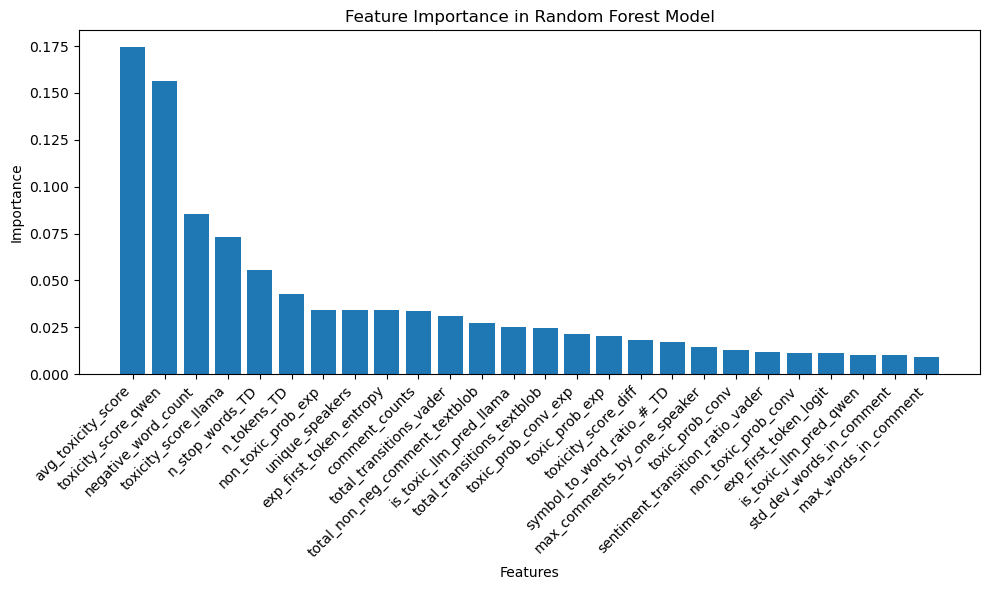

,feature,importance
4,avg_toxicity_score,0.174650
1,toxicity_score_qwen,0.156620
10,negative_word_count,0.085177
0,toxicity_score_llama,0.073039
23,n_stop_words_TD,0.055505
21,n_tokens_TD,0.042489
12,non_toxic_prob_exp,0.034437
7,unique_speakers,0.034331
11,exp_first_token_entropy,0.033949
15,comment_counts,0.033517


In [106]:
plot_feature_importance(model, top_features)